In [ ]:
# Download and import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Download dataset
!wget https://drive.usercontent.google.com/download?id=1U3J1DuXPd_7aCJNxY6AvPbd-JyqXfAS9&export=download&authuser=0&confirm=t&uuid=61cff6f5-1e81-4493-88df-17f5f19f35e0&at=AO7h07drPPJB6YPu21EKZwQcdM7e:1726828150761

--2024-10-07 18:38:05--  https://drive.usercontent.google.com/download?id=1U3J1DuXPd_7aCJNxY6AvPbd-JyqXfAS9
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.8.132, 2404:6800:4008:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.8.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27052110 (26M) [application/octet-stream]
Saving to: ‘download?id=1U3J1DuXPd_7aCJNxY6AvPbd-JyqXfAS9’

download?id=1U3J1Du 100%[===================>]  25.80M  42.5MB/s    in 0.6s    

2024-10-07 18:38:09 (42.5 MB/s) - ‘download?id=1U3J1DuXPd_7aCJNxY6AvPbd-JyqXfAS9’ saved [27052110/27052110]



In [ ]:
# Constance
random_state = 42

In [ ]:
# Read CSV
df = pd.read_csv('/content/download?id=1U3J1DuXPd_7aCJNxY6AvPbd-JyqXfAS9')

# Data cleaning
split_payment_behavior = df['Payment_Behaviour'].str.split('_').str
df.rename(columns={'Credit_Score':'Label'}, inplace=True)
df['Spending_Behavior'] = split_payment_behavior[0].map({'High': 1, 'Low': 0})
df['Payment_Behavior'] = split_payment_behavior[2].map({'Small': 0, 'Medium': 1, 'Large': 2})
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map({'Yes': 1, 'No': 0})
df['Credit_Mix'] = df['Credit_Mix'].map({'Bad': -1, 'Standard': 0, 'Good': 1})
df['Label'] = df['Label'].map({'Poor': -1, 'Standard': 0, 'Good': 1})

df.head()

,Customer_ID,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Last_Loan_7,Last_Loan_6,Last_Loan_5,Last_Loan_4,Last_Loan_3,Last_Loan_2,Last_Loan_1,Label,Spending_Behavior,Payment_Behavior
0,CUS_0x98ed,31,Journalist,22229.060,1672.421667,6,4,5,3,10,...,No Loan,No Loan,No Loan,No Loan,Debt Consolidation Loan,Home Equity Loan,Debt Consolidation Loan,0,1,1
1,CUS_0x36b4,43,Musician,17060.705,1685.725417,8,3,11,4,24,...,No Loan,No Loan,No Loan,Debt Consolidation Loan,Home Equity Loan,Auto Loan,Auto Loan,0,0,0
2,CUS_0x105b,24,Accountant,34428.210,2575.017500,2,4,8,0,3,...,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,1,1,0
3,CUS_0x4c4a,21,Accountant,12613.920,1155.160000,4,6,13,3,14,...,No Loan,No Loan,No Loan,No Loan,Personal Loan,Student Loan,Home Equity Loan,0,0,1
4,CUS_0x612f,31,Journalist,34775.160,3048.930000,7,9,25,5,20,...,No Loan,No Loan,Auto Loan,Mortgage Loan,Auto Loan,Payday Loan,Not Specified,-1,1,1


In [ ]:
# Calculate correlation between label and features
df_numeric = df.select_dtypes(include=['float64', 'int64'])
label_features_correlation_matrix = df_numeric.corr()
abs_label_features_correlation_df = label_features_correlation_matrix['Label'].map(abs).sort_values()
important_features = abs_label_features_correlation_df[abs_label_features_correlation_df > 0.2]
columns = important_features.index.tolist()
abs_label_features_correlation_df

,Label
Credit_Utilization_Ratio,0.045793
Total_EMI_per_month,0.070619
Spending_Behavior,0.090938
Payment_Behavior,0.111699
Amount_invested_monthly,0.154277
Age,0.160356
Changed_Credit_Limit,0.169506
Monthly_Balance,0.208506
Monthly_Inhand_Salary,0.209921
Annual_Income,0.212606


In [ ]:
# Only select important columns
df = df[columns]
df.head()

,Monthly_Balance,Monthly_Inhand_Salary,Annual_Income,Num_of_Loan,Num_of_Delayed_Payment,Outstanding_Debt,Num_Bank_Accounts,Credit_History_Age,Num_Credit_Card,Delay_from_due_date,Num_Credit_Inquiries,Payment_of_Min_Amount,Interest_Rate,Credit_Mix,Label
0,321.019683,1672.421667,22229.060,3,10,1396.14,6,156,4,10,9,1,5,0,0
1,327.009597,1685.725417,17060.705,4,8,268.81,8,269,3,24,2,1,11,0,0
2,432.727105,2575.017500,34428.210,0,12,180.70,2,326,4,3,0,0,8,1,1
3,346.630494,1155.160000,12613.920,3,17,569.11,4,376,6,14,3,1,13,0,0
4,360.325808,3048.930000,34775.160,5,20,3003.45,7,162,9,20,6,1,25,-1,-1


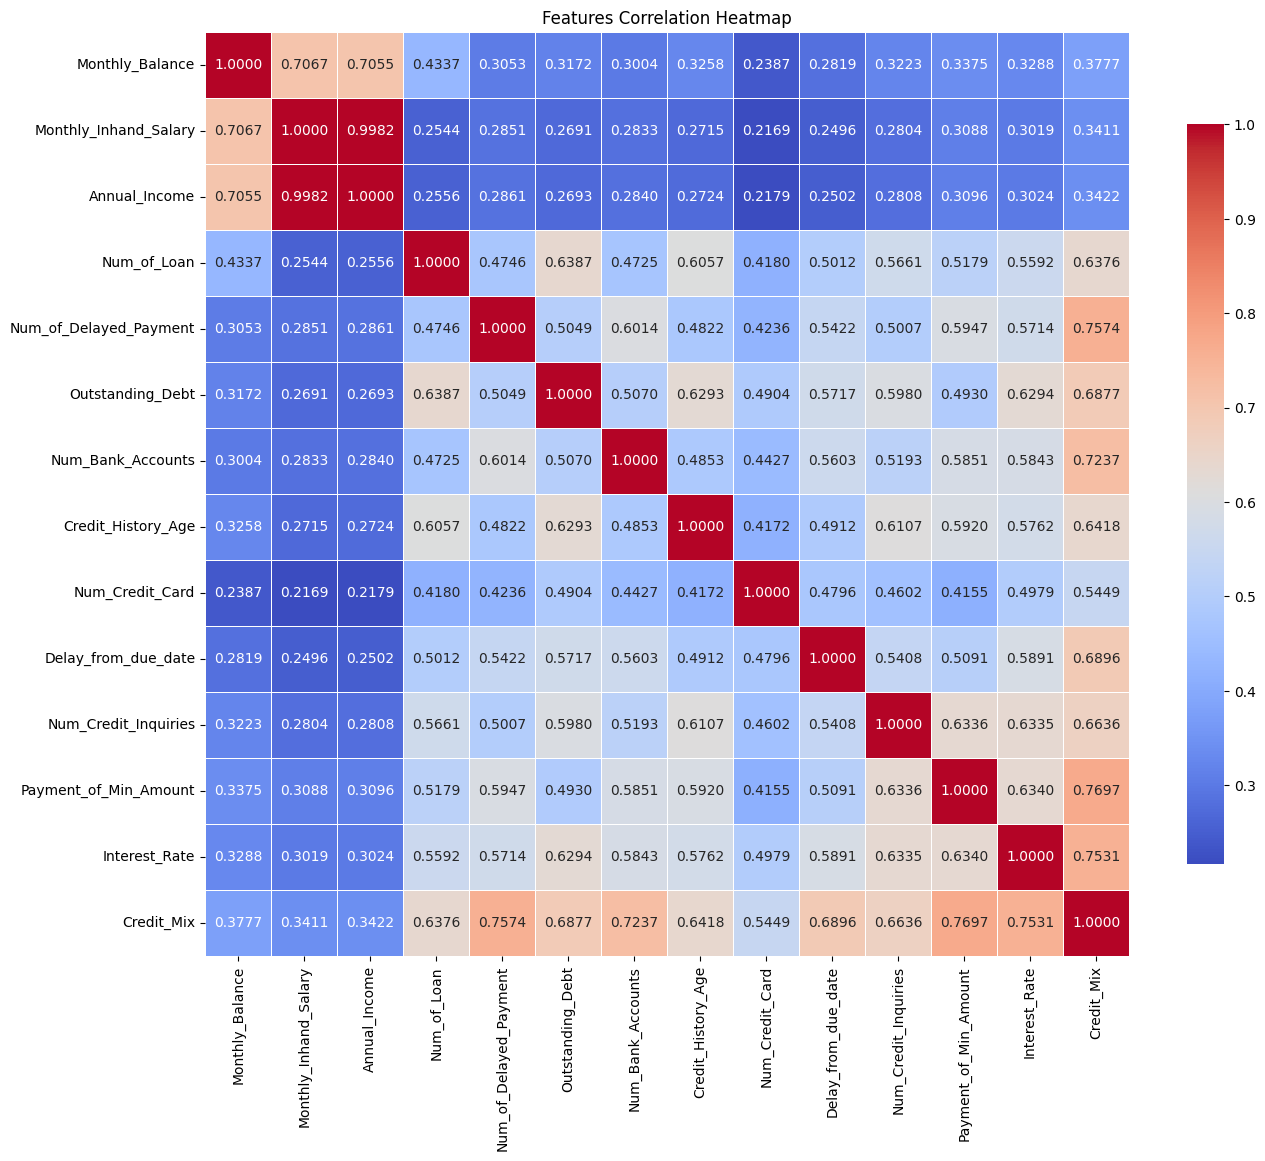

In [ ]:
# Calculate correlation between features
df_numeric = df.select_dtypes(include=['float64', 'int64']).drop(columns=['Label'])
abs_correlation_matrix = df_numeric.corr().map(abs)
plt.figure(figsize=(15, 12))
sns.heatmap(abs_correlation_matrix, annot=True, fmt=".4f", cmap='coolwarm',
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)
plt.title('Features Correlation Heatmap')
plt.show()

In [ ]:
# Sort to see which pair of features has the highest correlation
features_correlation = (abs_correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates())
features_correlation = features_correlation[features_correlation != 1]
features_correlation = features_correlation[features_correlation >= 0.7]
features_correlation

Monthly_Inhand_Salary  Annual_Income             0.998201
Credit_Mix             Payment_of_Min_Amount     0.769721
                       Num_of_Delayed_Payment    0.757443
                       Interest_Rate             0.753124
Num_Bank_Accounts      Credit_Mix                0.723669
Monthly_Balance        Monthly_Inhand_Salary     0.706741
Annual_Income          Monthly_Balance           0.705528
dtype: float64

Counter({'Standard': 53174, 'Poor': 28998, 'Good': 17828})


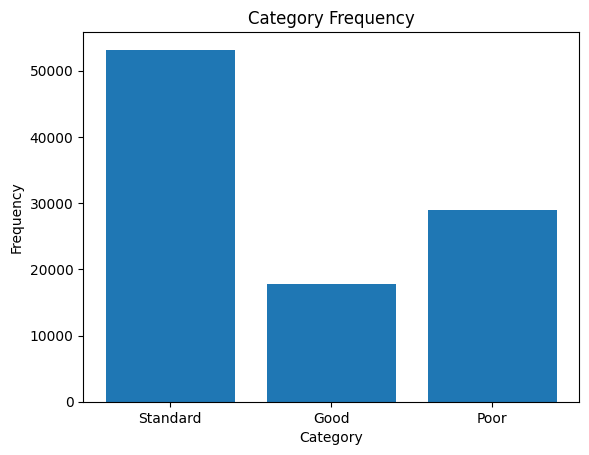

In [ ]:
# Calculate label data distribution
count = Counter(df['Label'].map({-1: 'Poor', 0: 'Standard', 1: 'Good'}))
print(count)

values = count.values()
categories = count.keys()

plt.bar(categories, values)
plt.title('Category Frequency')
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Prepare data for RandomForestClassifier
df_m1 = df.drop(columns=['Monthly_Inhand_Salary']).reset_index(drop=True)
X_m1 = df_m1.drop(columns=['Label'])
y_m1 = df_m1['Label']
X_train_m1, X_test_m1, y_train_m1, y_test_m1 = train_test_split(X_m1, y_m1, test_size=0.1,
                                                                random_state=random_state, stratify=y_m1)

In [ ]:
# Train RandomForestClassifier
rfc_model_gini = RandomForestClassifier(random_state=random_state, criterion='gini', n_estimators=100)
rfc_model_gini.fit(X_train_m1, y_train_m1)
y_pred_gini_m1 = rfc_model_gini.predict(X_test_m1)

rfc_model_entropy = RandomForestClassifier(random_state=random_state, criterion='entropy', n_estimators=100)
rfc_model_entropy.fit(X_train_m1, y_train_m1)
y_pred_entropy_m1 = rfc_model_entropy.predict(X_test_m1)

accuracy_gini_m1 = accuracy_score(y_test_m1, y_pred_gini_m1)
accuracy_entropy_m1 = accuracy_score(y_test_m1, y_pred_entropy_m1)

print('Accuracy of model with gini as loss function: ', accuracy_gini_m1)
print('Accuracy of model with entropy as loss function: ', accuracy_entropy_m1)


Accuracy of model with gini as loss function:  0.8209
Accuracy of model with entropy as loss function:  0.8193


Accuracy: 0.8209
Precision: 0.8210870573477917
Recall: 0.8209
F1 Score: 0.8209116445638992


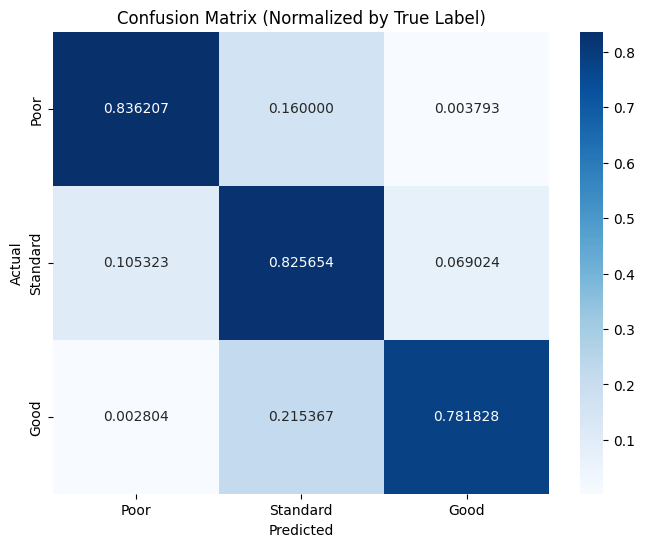

In [ ]:
# Random Forest Classifier best model metrics
precision_m1 = precision_score(y_test_m1, y_pred_gini_m1, average='weighted')
recall_m1 = recall_score(y_test_m1, y_pred_gini_m1, average='weighted')
f1_m1 = f1_score(y_test_m1, y_pred_gini_m1, average='weighted')
cm_m1 = confusion_matrix(y_test_m1, y_pred_gini_m1, normalize='true')

# Print the metrics for final test
print("Accuracy:", accuracy_gini_m1)
print("Precision:", precision_m1)
print("Recall:", recall_m1)
print("F1 Score:", f1_m1)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_m1, annot=True, fmt='f', cmap='Blues')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Poor', 'Standard', 'Good'], fontsize=10)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Poor', 'Standard', 'Good'], fontsize=10)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Normalized by True Label)')
plt.show()


In [ ]:
# Prepare data for LogisticRegression
df_m2 = df.drop(columns=['Monthly_Inhand_Salary']).reset_index(drop=True)
X_m2 = df_m2.drop(columns=['Label'])
y_m2 = df_m2['Label']
# Split into train and test
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(
    X_m2, y_m2, test_size=0.1, stratify=y_m2, random_state=random_state
)

In [ ]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_train_m2_scaled = scaler.fit_transform(X_train_m2)
X_test_m2_scaled = scaler.transform(X_test_m2)

# Define the model and parameter grid for GridSearchCV
lr_model = LogisticRegression(max_iter=2000, class_weight='balanced')
param_grid = {
    'solver': ['saga', 'liblinear'],
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train_m2_scaled, y_train_m2)

# Get the best model
best_model = grid_search.best_estimator_

# Test the final model
y_pred_test_m2 = best_model.predict(X_test_m2_scaled)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Accuracy: 0.6554
Precision: 0.6982672849065094
Recall: 0.6554
F1 Score: 0.6588912830073985


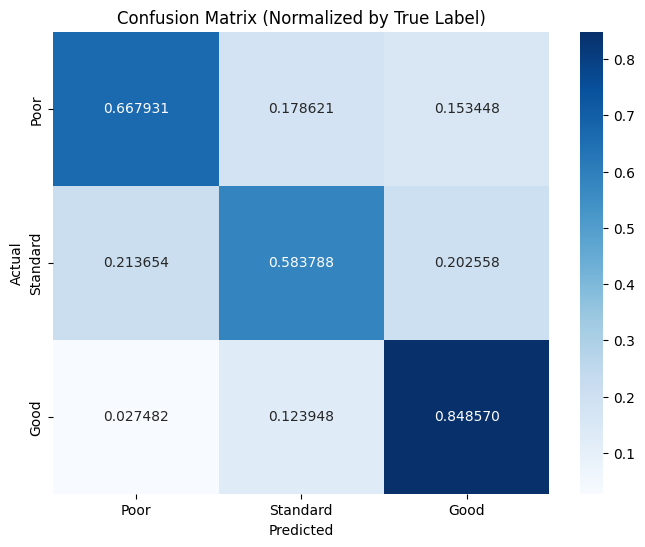

In [ ]:
# Logistic Regression best model metrics
accuracy_m2 = accuracy_score(y_test_m2, y_pred_test_m2)
precision_m2 = precision_score(y_test_m2, y_pred_test_m2, average='weighted')
recall_m2 = recall_score(y_test_m2, y_pred_test_m2, average='weighted')
f1_m2 = f1_score(y_test_m2, y_pred_test_m2, average='weighted')
cm_m2 = confusion_matrix(y_test_m2, y_pred_test_m2, normalize='true')

# Print the metrics for final test
print("Accuracy:", accuracy_m2)
print("Precision:", precision_m2)
print("Recall:", recall_m2)
print("F1 Score:", f1_m2)

# Plot the average confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_m2, annot=True, fmt='f', cmap='Blues')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Poor', 'Standard', 'Good'], fontsize=10)
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Poor', 'Standard', 'Good'], fontsize=10)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Normalized by True Label)')
plt.show()
